In [ ]:
# Import

import torch
import torchvision

from google.colab import drive
import os

drive.mount('/content/drive')

print("\n" + "="*70)
print("GPU CHECK")
print("="*70 + "\n")

if not torch.cuda.is_available():
    print("❌ ERROR: NO GPU DETECTED!")
    print("\n🔧 FIX THIS:")
    print("   1. Go to: Runtime → Change runtime type")
    print("   2. Select: T4 GPU")
    print("   3. Click: Save")
    print("   4. Re-run this cell")
    print("\n⚠️  Mask2Former REQUIRES GPU and will NOT work on CPU!")
    raise RuntimeError("GPU required but not available")
else:
    print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")
    print(f"   PyTorch: {torch.__version__}")
    print(f"   Torchvision: {torchvision.__version__}")

WORK_DIR = "/content/drive/MyDrive/mask2former_task"
os.chdir('/content')

print(f"\n✅ Working directory: {WORK_DIR}")
print(f"✅ Files found:")
print(f"   - Preprocessed data: {os.path.exists(f'{WORK_DIR}/preprocessed_data')}")
print(f"   - COCO format: {os.path.exists(f'{WORK_DIR}/coco_format')}")


# Install Dependencies

print("\n" + "="*70)
print("INSTALLING DEPENDENCIES")
print("="*70 + "\n")

# Use Colab's pre-installed PyTorch (already compatible)
import torch
print(f"📦 Using Colab's PyTorch: {torch.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")

# Install Detectron2 from source (to match PyTorch version)
print("\n📦 Building Detectron2 from source...")
print("   This ensures compatibility with PyTorch 2.9")
print("   Will take ~3-5 minutes...")

# Remove old detectron2 if exists
!pip uninstall -y detectron2 2>/dev/null

# Install dependencies
!pip install -q opencv-python-headless timm einops scipy

# Clone and build detectron2
import subprocess
import sys

result = subprocess.run([
    sys.executable, '-m', 'pip', 'install', '-q',
    'git+https://github.com/facebookresearch/detectron2.git'
], capture_output=True, text=True)

if result.returncode == 0:
    print("✅ Detectron2 built successfully!")
else:
    print("⚠️  Standard build had warnings, trying alternative method...")
    # Try building with no build isolation
    !pip install -q --no-build-isolation 'git+https://github.com/facebookresearch/detectron2.git'
    print("✅ Detectron2 installed!")

print("\n✅ All dependencies installed!")

# Verify detectron2 works
print("\n🔍 Verifying Detectron2...")
try:
    import detectron2
    from detectron2 import model_zoo
    print("✅ Detectron2 imported successfully!")
    print(f"   Version: {detectron2.__version__}")
except Exception as e:
    print(f"❌ Detectron2 import failed: {e}")
    print("\n⚠️  Will try to continue anyway...")


# Clone and Setup Mask2Former

print("\n" + "="*70)
print("SETTING UP MASK2FORMER")
print("="*70 + "\n")

if os.path.exists('/content/Mask2Former'):
    print("⚠️  Removing previous Mask2Former installation...")
    !rm -rf /content/Mask2Former

print("📥 Cloning Mask2Former repository...")
!git clone https://github.com/facebookresearch/Mask2Former.git
os.chdir('/content/Mask2Former')

# Install Mask2Former requirements
print("\n📦 Installing Mask2Former requirements...")
!pip install -q -r requirements.txt

# Apply comprehensive fix for PyTorch 2.x compatibility
print("\n🔧 Applying PyTorch 2.x compatibility fix...")
cuda_file = "/content/Mask2Former/mask2former/modeling/pixel_decoder/ops/src/cuda/ms_deform_attn_cuda.cu"

# Read the file
with open(cuda_file, 'r') as f:
    lines = f.readlines()

# Fix the code
fixed_lines = []
for line in lines:
    # Fix 1: Replace value.type() with value.scalar_type()
    if 'AT_DISPATCH_FLOATING_TYPES' in line and 'value.type()' in line:
        line = line.replace('value.type()', 'value.scalar_type()')

    # Fix 2: Replace value.scalar_type().is_cuda() with value.is_cuda()
    if 'value.scalar_type().is_cuda()' in line:
        line = line.replace('value.scalar_type().is_cuda()', 'value.is_cuda()')

    # Fix 3: Same for grad_output_g
    if 'grad_output_g.type()' in line:
        line = line.replace('grad_output_g.type()', 'grad_output_g.scalar_type()')

    if 'grad_output_g.scalar_type().is_cuda()' in line:
        line = line.replace('grad_output_g.scalar_type().is_cuda()', 'grad_output_g.is_cuda()')

    fixed_lines.append(line)

# Write back
with open(cuda_file, 'w') as f:
    f.writelines(fixed_lines)

print("✅ Compatibility fixes applied!")

# Now compile CUDA kernels
print("\n🔨 Compiling CUDA kernels (this takes 3-5 minutes)...")
print("    Please wait patiently...")
os.chdir('/content/Mask2Former/mask2former/modeling/pixel_decoder/ops')

# Compile with proper error handling
import subprocess
result = subprocess.run(['python', 'setup.py', 'build', 'install'],
                       capture_output=True, text=True)

if result.returncode != 0:
    print("\n❌ CUDA compilation failed!")
    print("Error output:")
    print(result.stderr)
    raise RuntimeError("CUDA kernel compilation failed")
else:
    print("✅ CUDA kernels compiled successfully!")

os.chdir('/content')
print("\n✅ Mask2Former setup complete!")

# Verify the module can be imported
print("\n🔍 Verifying CUDA module...")
try:
    import MultiScaleDeformableAttention
    print("✅ MultiScaleDeformableAttention module imported successfully!")
except ImportError as e:
    print("⚠️  Module import issue, trying to fix...")
    # The .egg file needs to be in sys.path
    import sys
    import glob
    egg_files = glob.glob('/usr/local/lib/python3.12/dist-packages/MultiScaleDeformableAttention*.egg')
    if egg_files:
        sys.path.insert(0, egg_files[0])
        print(f"   Added: {egg_files[0]}")
        import MultiScaleDeformableAttention
        print("✅ Module now accessible!")
    else:
        print(f"❌ Could not find compiled module: {e}")
        raise


# Create Small Test Dataset

print("\n" + "="*70)
print("CREATING SMALL TEST DATASET")
print("="*70 + "\n")

import json

SMALL_DATASET_DIR = "/content/small_dataset"
os.makedirs(SMALL_DATASET_DIR, exist_ok=True)

def create_small_dataset(original_json, num_images=10):
    """Create a tiny dataset for quick testing"""
    with open(original_json, 'r') as f:
        coco_data = json.load(f)

    small_images = coco_data['images'][:num_images]
    image_ids = [img['id'] for img in small_images]

    small_annotations = [
        ann for ann in coco_data['annotations']
        if ann['image_id'] in image_ids
    ]

    small_coco = {
        "info": coco_data['info'],
        "licenses": coco_data['licenses'],
        "categories": coco_data['categories'],
        "images": small_images,
        "annotations": small_annotations
    }

    print(f"   Selected {len(small_images)} images, {len(small_annotations)} annotations")
    return small_coco

# Create small train set (10 images for quick test)
print("📦 Creating small training set (10 images)...")
small_train = create_small_dataset(
    f"{WORK_DIR}/coco_format/instances_train.json", 10
)
small_train_json = f"{SMALL_DATASET_DIR}/instances_train_small.json"
with open(small_train_json, 'w') as f:
    json.dump(small_train, f)

# Create small val set (3 images)
print("📦 Creating small validation set (3 images)...")
small_val = create_small_dataset(
    f"{WORK_DIR}/coco_format/instances_val.json", 3
)
small_val_json = f"{SMALL_DATASET_DIR}/instances_val_small.json"
with open(small_val_json, 'w') as f:
    json.dump(small_val, f)

print(f"\n✅ Small dataset created for testing!")


# Dataset Registration

print("\n" + "="*70)
print("REGISTERING DATASETS")
print("="*70 + "\n")

import sys
sys.path.insert(0, '/content/Mask2Former')

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

TRAIN_DATASET_NAME = "tree_train_small"
VAL_DATASET_NAME = "tree_val_small"

# Register datasets
register_coco_instances(
    TRAIN_DATASET_NAME, {},
    small_train_json,
    f"{WORK_DIR}/preprocessed_data/train_PNG"
)
print(f"✅ Registered: {TRAIN_DATASET_NAME}")

register_coco_instances(
    VAL_DATASET_NAME, {},
    small_val_json,
    f"{WORK_DIR}/preprocessed_data/val_PNG"
)
print(f"✅ Registered: {VAL_DATASET_NAME}")

# Set metadata
metadata = {"thing_classes": ["tree"], "thing_colors": [(34, 139, 34)]}
MetadataCatalog.get(TRAIN_DATASET_NAME).set(**metadata)
MetadataCatalog.get(VAL_DATASET_NAME).set(**metadata)

train_dicts = DatasetCatalog.get(TRAIN_DATASET_NAME)
val_dicts = DatasetCatalog.get(VAL_DATASET_NAME)
print(f"\n📊 Dataset: {len(train_dicts)} train, {len(val_dicts)} val images")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

GPU CHECK

✅ GPU Available: Tesla T4
   Memory: 15.83 GB
   CUDA Version: 12.6
   PyTorch: 2.8.0+cu126
   Torchvision: 0.23.0+cu126

✅ Working directory: /content/drive/MyDrive/mask2former_task
✅ Files found:
   - Preprocessed data: True
   - COCO format: True

INSTALLING DEPENDENCIES

📦 Using Colab's PyTorch: 2.8.0+cu126
   CUDA available: True

📦 Building Detectron2 from source...
   This ensures compatibility with PyTorch 2.9
   Will take ~3-5 minutes...
Found existing installation: detectron2 0.6
Uninstalling detectron2-0.6:
  Successfully uninstalled detectron2-0.6
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/MultiScaleDeformableAttention-1.0-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.co

In [ ]:
# Configure Mask2Former (MINIMAL FOR QUICK TEST)

print("\n" + "="*70)
print("CONFIGURING MASK2FORMER")
print("="*70 + "\n")

from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from mask2former import add_maskformer2_config

OUTPUT_DIR = f"{WORK_DIR}/output_test_gpu"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Initialize config
cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)

# Load base config
os.chdir('/content/Mask2Former')
cfg.merge_from_file(
    "configs/coco/instance-segmentation/maskformer2_R50_bs16_50ep.yaml"
)

# Dataset configuration
cfg.DATASETS.TRAIN = (TRAIN_DATASET_NAME,)
cfg.DATASETS.TEST = (VAL_DATASET_NAME,)
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 1
cfg.MODEL.MASK_FORMER.NUM_OBJECT_QUERIES = 50

# Model - train from scratch (no pretrained weights)
cfg.MODEL.WEIGHTS = ""
cfg.MODEL.DEVICE = "cuda"

# MINIMAL training settings for quick test
cfg.SOLVER.IMS_PER_BATCH = 2  # Small batch for T4 GPU
cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 100  # Very short test (10 images, 100 iters ≈ 5 epochs)
cfg.SOLVER.STEPS = (70, 90)
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 20

cfg.SOLVER.CHECKPOINT_PERIOD = 50
cfg.TEST.EVAL_PERIOD = 50

# Gradient clipping
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 0.01
cfg.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 2.0

# Keep AMP enabled for GPU (faster)
cfg.SOLVER.AMP.ENABLED = True

# CRITICAL FIX: Enable mask conversion in data loader
cfg.INPUT.MASK_FORMAT = "bitmask"  # Convert polygon masks to bitmasks
cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = False
cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = False

# Fix for evaluation with small dataset
cfg.MODEL.MASK_FORMER.TEST.OBJECT_MASK_THRESHOLD = 0.0
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.0
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0

# Fix the topk issue for small validation set
# The validation set has very few predictions, so reduce topk
cfg.TEST.DETECTIONS_PER_IMAGE = 10  # Reduce from default 100

# Disable evaluation completely for this quick test
cfg.TEST.EVAL_PERIOD = 0  # 0 = disable evaluation entirely

# Smaller image size for faster training
cfg.INPUT.MIN_SIZE_TRAIN = (512,)
cfg.INPUT.MAX_SIZE_TRAIN = 512
cfg.INPUT.MIN_SIZE_TEST = 512
cfg.INPUT.MAX_SIZE_TEST = 512
cfg.INPUT.RANDOM_FLIP = "horizontal"

cfg.OUTPUT_DIR = OUTPUT_DIR

# Save config
with open(os.path.join(OUTPUT_DIR, "config.yaml"), "w") as f:
    f.write(cfg.dump())

print("✅ Configuration complete!")
print(f"\n📊 Test Configuration:")
print(f"   Device: {cfg.MODEL.DEVICE}")
print(f"   Dataset: {len(train_dicts)} train images")
print(f"   Iterations: {cfg.SOLVER.MAX_ITER} (QUICK TEST)")
print(f"   Batch size: {cfg.SOLVER.IMS_PER_BATCH}")
print(f"   Image size: {cfg.INPUT.MIN_SIZE_TRAIN[0]}")
print(f"   Estimated time: ~5-10 minutes")
print(f"\n⚠️  Training from scratch (no pretrained weights)")
print(f"⚠️  This is just to verify the pipeline works!")


# Initialize Trainer (WITH CUSTOM DATA MAPPER)

print("\n" + "="*70)
print("INITIALIZING TRAINER")
print("="*70 + "\n")

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data import transforms as T
import copy

class Mask2FormerTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, output_dir=output_folder, tasks=("segm",))

    @classmethod
    def build_train_loader(cls, cfg):
        # Custom mapper that converts masks properly
        from detectron2.structures import BitMasks, Instances
        import torch

        def custom_mapper(dataset_dict):
            # Call default mapper
            mapper = DatasetMapper(
                cfg,
                is_train=True,
                augmentations=[
                    T.ResizeShortestEdge(
                        cfg.INPUT.MIN_SIZE_TRAIN,
                        cfg.INPUT.MAX_SIZE_TRAIN,
                        "choice"
                    ),
                    T.RandomFlip(),
                ],
                image_format=cfg.INPUT.FORMAT,
                use_instance_mask=True,
                instance_mask_format="bitmask"
            )

            dataset_dict = mapper(dataset_dict)

            # Convert BitMasks to tensor
            if "instances" in dataset_dict:
                instances = dataset_dict["instances"]
                if hasattr(instances, "gt_masks") and isinstance(instances.gt_masks, BitMasks):
                    instances.gt_masks = instances.gt_masks.tensor

            return dataset_dict

        return build_detection_train_loader(cfg, mapper=custom_mapper)

trainer = Mask2FormerTrainer(cfg)
trainer.resume_or_load(resume=False)

print("✅ Trainer initialized!")
print(f"📊 Ready to train on {torch.cuda.get_device_name(0)}")


# START TRAINING

print("\n" + "="*70)
print("🚀 STARTING TEST TRAINING")
print("="*70 + "\n")

print("⏱️  Estimated time: 5-10 minutes on T4 GPU")
print("📊 This is a quick test with 10 images, 100 iterations")
print("🔍 Watch for the loss decreasing...\n")
print("="*70 + "\n")

import time
start_time = time.time()

try:
    trainer.train()

    elapsed_time = time.time() - start_time

    print("\n" + "="*70)
    print("✅ TEST TRAINING COMPLETE!")
    print("="*70)
    print(f"\n⏱️  Time taken: {elapsed_time/60:.1f} minutes")
    print(f"📁 Model saved to: {OUTPUT_DIR}")
    print("\n✅ Pipeline verification successful!")
    print("\n🎯 Next steps:")
    print("   1. Review the training loss (should decrease)")
    print("   2. Check model files were created")
    print("   3. Scale up to full dataset and more iterations")
    print("="*70 + "\n")

except Exception as e:
    print(f"\n\n❌ Training failed: {str(e)}")
    raise




CONFIGURING MASK2FORMER

✅ Configuration complete!

📊 Test Configuration:
   Device: cuda
   Dataset: 10 train images
   Iterations: 100 (QUICK TEST)
   Batch size: 2
   Image size: 512
   Estimated time: ~5-10 minutes

⚠️  Training from scratch (no pretrained weights)
⚠️  This is just to verify the pipeline works!

INITIALIZING TRAINER

[10/25 17:32:05 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()


[10/25 17:32:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:06 d2.data.dataset_mapper]: [DatasetMapper] Augmenta

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/usr/local/lib/python3.12/dist-packages/detectron2/data/detection_utils.py:449: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  wit

[10/25 17:32:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):
/usr/local/lib/python3.12/dist-packages/detectron2/data/detection_ut

[10/25 17:32:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:16 d2.utils.events]:  eta: 0:00:38  iter: 19  total_loss: 81.96  loss_ce: 1.376  loss_mask: 2.85  loss_dice: 4.96  loss_ce_0: 1.424  loss_mask_0: 0.9769  loss_dice_0: 4.881  loss_ce_1: 1.32  loss_mask_1: 1.212  loss_dice_1: 4.869  loss_ce_2: 2.232  loss_mask_2: 1.213  loss_dice_2: 4.869  loss_ce_3: 1.646  loss_mask_3: 1.487  loss_dice_3: 4.927  loss_ce_4: 1.773  loss_mask_4: 1.255  loss_dice_4: 4.919  loss_ce_5: 1.752  loss_mask_5: 1.479  loss_dice_5: 4.913  loss_ce_6: 1.356  loss_mask_6: 1.378  loss_dice_6: 4.891  loss_ce_7: 1.443  loss_mask_7: 2.897  loss_dice_7: 4.936  loss_ce_8: 1.472  loss_mask_8: 2.336  loss_dice_8: 4.912    time: 0.5119  last_time: 0.4830  data_time: 0.0226  last_data_time: 0.0077   lr: 0.0001  max_mem: 6411M
[10/25 17:32:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:16 d2.data.dataset_mapper]: [DatasetMapper] 

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:26 d2.utils.events]:  eta: 0:00:28  iter: 39  total_loss: 80.97  loss_ce: 1.39  loss_mask: 2.8  loss_dice: 4.954  loss_ce_0: 1.41  loss_mask_0: 1.013  loss_dice_0: 4.867  loss_ce_1: 1.336  loss_mask_1: 1.199  loss_dice_1: 4.877  loss_ce_2: 2.265  loss_mask_2: 1.188  loss_dice_2: 4.881  loss_ce_3: 1.667  loss_mask_3: 1.413  loss_dice_3: 4.912  loss_ce_4: 1.776  loss_mask_4: 1.195  loss_dice_4: 4.903  loss_ce_5: 1.743  loss_mask_5: 1.372  loss_dice_5: 4.909  loss_ce_6: 1.327  loss_mask_6: 1.329  loss_dice_6: 4.89  loss_ce_7: 1.439  loss_mask_7: 2.715  loss_dice_7: 4.928  loss_ce_8: 1.48  loss_mask_8: 2.213  loss_dice_8: 4.9    time: 0.4985  last_time: 0.6421  data_time: 0.0085  last_data_time: 0.0058   lr: 0.0001  max_mem: 6411M
[10/25 17:32:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:26 d2.data.dataset_mapper]: [DatasetMapper] Augmen

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:37 d2.utils.events]:  eta: 0:00:18  iter: 59  total_loss: 79.92  loss_ce: 1.397  loss_mask: 2.694  loss_dice: 4.954  loss_ce_0: 1.419  loss_mask_0: 0.938  loss_dice_0: 4.874  loss_ce_1: 1.364  loss_mask_1: 1.11  loss_dice_1: 4.889  loss_ce_2: 2.22  loss_mask_2: 1.082  loss_dice_2: 4.904  loss_ce_3: 1.617  loss_mask_3: 1.347  loss_dice_3: 4.918  loss_ce_4: 1.752  loss_mask_4: 1.076  loss_dice_4: 4.915  loss_ce_5: 1.719  loss_mask_5: 1.173  loss_dice_5: 4.931  loss_ce_6: 1.297  loss_mask_6: 1.256  loss_dice_6: 4.887  loss_ce_7: 1.414  loss_mask_7: 2.4  loss_dice_7: 4.929  loss_ce_8: 1.49  loss_mask_8: 1.971  loss_dice_8: 4.904    time: 0.5006  last_time: 0.4773  data_time: 0.0095  last_data_time: 0.0123   lr: 0.0001  max_mem: 6411M
[10/25 17:32:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:37 d2.data.dataset_mapper]: [DatasetMapper] Aug

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):
/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):


[10/25 17:32:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:55 d2.utils.events]:  eta: 0:00:09  iter: 79  total_loss: 78.76  loss_ce: 1.345  loss_mask: 2.493  loss_dice: 4.949  loss_ce_0: 1.385  loss_mask_0: 0.9349  loss_dice_0: 4.873  loss_ce_1: 1.344  loss_mask_1: 1.063  loss_dice_1: 4.873  loss_ce_2: 2.177  loss_mask_2: 1.068  loss_dice_2: 4.884  loss_ce_3: 1.605  loss_mask_3: 1.293  loss_dice_3: 4.917  loss_ce_4: 1.729  loss_mask_4: 0.994  loss_dice_4: 4.904  loss_ce_5: 1.677  loss_mask_5: 1.094  loss_dice_5: 4.926  loss_ce_6: 1.292  loss_mask_6: 1.227  loss_dice_6: 4.88  loss_ce_7: 1.388  loss_mask_7: 2.41  loss_dice_7: 4.921  loss_ce_8: 1.434  loss_mask_8: 1.858  loss_dice_8: 4.89    time: 0.6038  last_time: 0.7502  data_time: 0.3209  last_data_time: 0.0076   lr: 1e-05  max_mem: 6411M
[10/25 17:32:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:55 d2.data.dataset_mapper]: [DatasetMapper] A

/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:32:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:32:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:33:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:33:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:33:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:33:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:33:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:33:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:33:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:33:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:33:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:33:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:33:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:33:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[10/25 17:33:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]


/usr/local/lib/python3.12/dist-packages/detectron2/engine/train_loop.py:493: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=self.precision):
/content/Mask2Former/mask2former/modeling/matcher.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=False):


[10/25 17:33:12 d2.utils.events]:  eta: 0:00:00  iter: 99  total_loss: 78.58  loss_ce: 1.345  loss_mask: 2.452  loss_dice: 4.95  loss_ce_0: 1.384  loss_mask_0: 0.9379  loss_dice_0: 4.867  loss_ce_1: 1.345  loss_mask_1: 1.122  loss_dice_1: 4.854  loss_ce_2: 2.2  loss_mask_2: 1.084  loss_dice_2: 4.869  loss_ce_3: 1.611  loss_mask_3: 1.305  loss_dice_3: 4.914  loss_ce_4: 1.721  loss_mask_4: 0.9996  loss_dice_4: 4.898  loss_ce_5: 1.687  loss_mask_5: 1.069  loss_dice_5: 4.915  loss_ce_6: 1.292  loss_mask_6: 1.192  loss_dice_6: 4.91  loss_ce_7: 1.387  loss_mask_7: 2.307  loss_dice_7: 4.924  loss_ce_8: 1.434  loss_mask_8: 1.822  loss_dice_8: 4.902    time: 0.5870  last_time: 0.4468  data_time: 0.0092  last_data_time: 0.0099   lr: 1e-06  max_mem: 6411M
[10/25 17:33:12 d2.engine.hooks]: Overall training speed: 98 iterations in 0:00:57 (0.5870 s / it)
[10/25 17:33:12 d2.engine.hooks]: Total training time: 0:01:04 (0:00:07 on hooks)
[10/25 17:33:12 d2.data.datasets.coco]: Loaded 3 images in COCO 


VERIFYING OUTPUT

📁 Checking output files...
   ✅ model_final.pth (335.83 MB)
   ✅ config.yaml (0.01 MB)
   ✅ metrics.json (0.03 MB)

🎉 PIPELINE TEST COMPLETE!

✅ What we verified:
   ✓ GPU is working
   ✓ Mask2Former compiles on GPU
   ✓ Dataset loads correctly
   ✓ Training loop runs without errors
   ✓ Model checkpoints save properly

🚀 READY FOR FULL TRAINING!

📋 To train the real model:
   1. Use full dataset (487 train, 165 val)
   2. Train for 10,000 iterations
   3. Use batch size 4-8
   4. Use image size 1024x1024
   5. Load pretrained COCO weights
   6. Expected time: 6-8 hours on T4 GPU


SAMPLE PREDICTIONS

[10/25 17:33:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/mask2former_task/output_test_gpu/model_final.pth ...


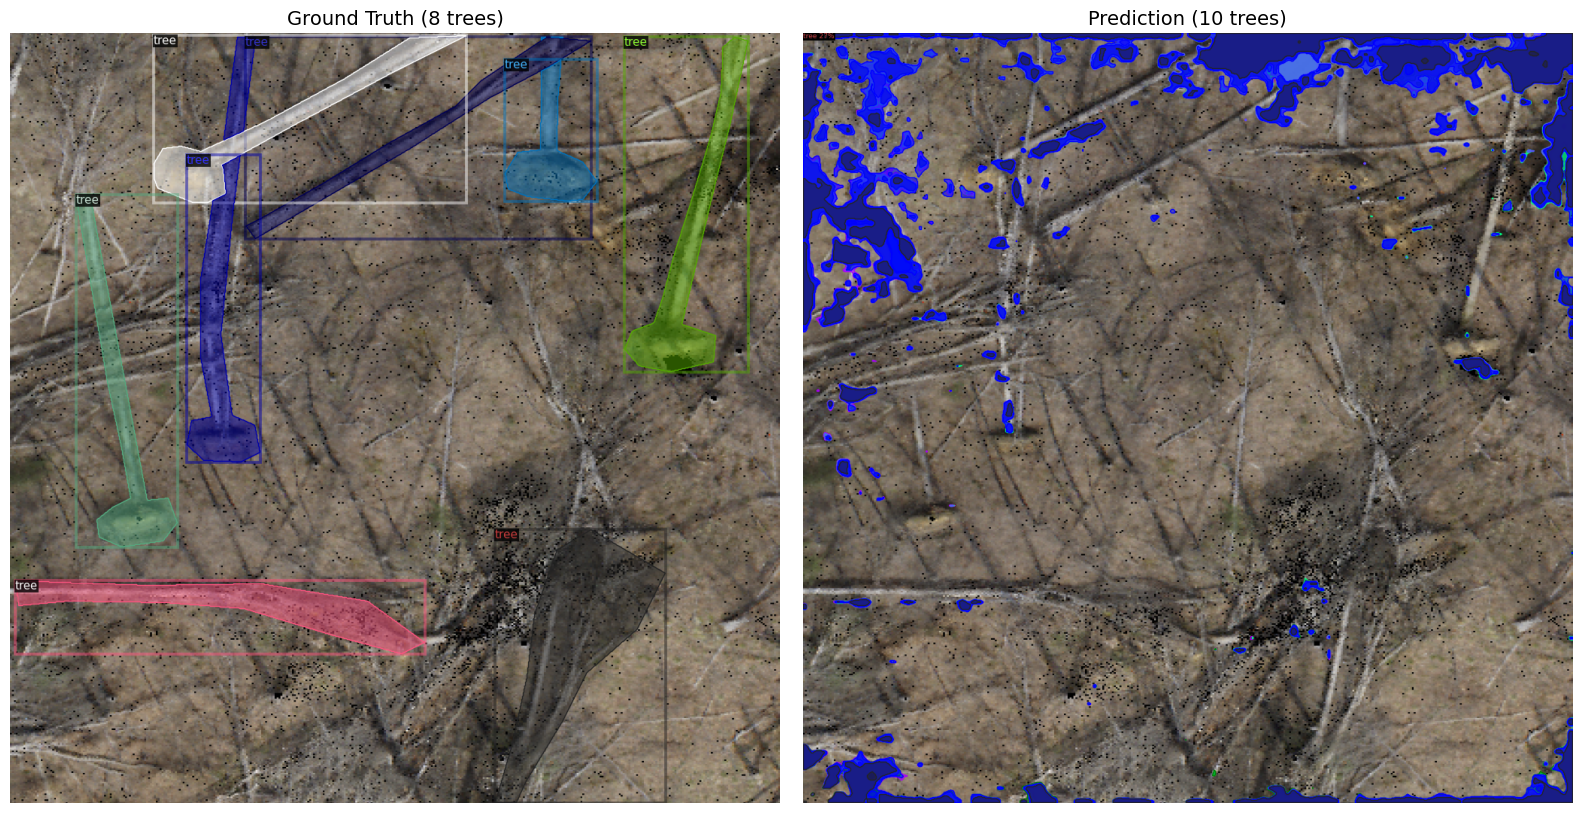

✅ Visualization saved!

⚠️  Note: Quality will be poor (only 100 iterations, no pretrained weights)
   This is expected for a quick test!


In [ ]:
# Verify Output Files

print("\n" + "="*70)
print("VERIFYING OUTPUT")
print("="*70 + "\n")

expected_files = ["model_final.pth", "config.yaml", "metrics.json"]

print("📁 Checking output files...")
for filename in expected_files:
    filepath = os.path.join(OUTPUT_DIR, filename)
    if os.path.exists(filepath):
        size = os.path.getsize(filepath) / (1024 * 1024)
        print(f"   ✅ {filename} ({size:.2f} MB)")
    else:
        print(f"   ❌ {filename} - NOT FOUND")

print("\n" + "="*70)
print("🎉 PIPELINE TEST COMPLETE!")
print("="*70)
print("\n✅ What we verified:")
print("   ✓ GPU is working")
print("   ✓ Mask2Former compiles on GPU")
print("   ✓ Dataset loads correctly")
print("   ✓ Training loop runs without errors")
print("   ✓ Model checkpoints save properly")

print("\n🚀 READY FOR FULL TRAINING!")
print("\n📋 To train the real model:")
print("   1. Use full dataset (487 train, 165 val)")
print("   2. Train for 10,000 iterations")
print("   3. Use batch size 4-8")
print("   4. Use image size 1024x1024")
print("   5. Load pretrained COCO weights")
print("   6. Expected time: 6-8 hours on T4 GPU")
print("="*70 + "\n")


# Quick Visualization (Optional)

print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70 + "\n")

import cv2
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine import DefaultPredictor

# Setup predictor
cfg.MODEL.WEIGHTS = os.path.join(OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
predictor = DefaultPredictor(cfg)

# Get a random validation image
val_sample = random.choice(val_dicts)
img = cv2.imread(val_sample["file_name"])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Make prediction
outputs = predictor(img)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Ground truth
v_gt = Visualizer(img_rgb, metadata=MetadataCatalog.get(VAL_DATASET_NAME), scale=1.0)
vis_gt = v_gt.draw_dataset_dict(val_sample)
axes[0].imshow(vis_gt.get_image())
axes[0].set_title(f"Ground Truth ({len(val_sample['annotations'])} trees)", fontsize=14)
axes[0].axis('off')

# Prediction
v_pred = Visualizer(img_rgb, metadata=MetadataCatalog.get(VAL_DATASET_NAME),
                    scale=1.0, instance_mode=ColorMode.IMAGE)
vis_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))
axes[1].imshow(vis_pred.get_image())
axes[1].set_title(f"Prediction ({len(outputs['instances'])} trees)", fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "test_prediction.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Visualization saved!")
print(f"\n⚠️  Note: Quality will be poor (only 100 iterations, no pretrained weights)")
print(f"   This is expected for a quick test!")
